In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext line_profiler

In [2]:
from functools import partial

import time
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [3]:
import jax
import jax.numpy as jnp

jax.config.update('jax_platform_name', 'cpu')

import diffrax
import equinox as eqx
import optax

from haiku import PRNGSequence

In [4]:
from cmaes import CMAwM

import exciting_environments as excenvs

import exciting_exciting_systems
# from exciting_exciting_systems.models.model_utils import simulate_ahead_with_env

from exciting_exciting_systems.evaluation.plotting_utils import plot_sequence

from exciting_exciting_systems.related_work.np_reimpl.env_utils import simulate_ahead_with_env
from exciting_exciting_systems.related_work.excitation_utils import generate_aprbs
from exciting_exciting_systems.related_work.np_reimpl.pendulum import Pendulum

---

In [5]:
# # setup PRNG
# key = jax.random.PRNGKey(seed=3333) # 21)

# data_key, opt_key, key = jax.random.split(key, 3)
# data_rng = PRNGSequence(data_key)

In [6]:
# batch_size = 1
# tau = 2e-2 # 5e-2

In [7]:
batch_size = 1
tau = 2e-2

env = Pendulum(
    batch_size=batch_size,
    tau=tau
)

- on runtime in jit generate a mask
- loss = jnp.sum(jnp.where(a != jnp.inf, a, 0)
- **this does not solve the issue with mixed-integer optimization!?**

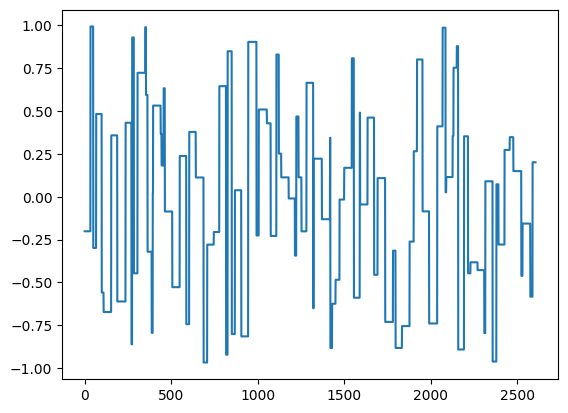

In [8]:
h = 100

# action_parameters = jnp.concatenate([
#     jax.random.uniform(
#         key=next(data_rng),
#         shape=(h,),
#         minval=-1,
#         maxval=1
#     ),
#     jax.random.randint(
#         key=next(data_rng),
#         shape=(h,),
#         minval=2,
#         maxval=50
#     )
# ])

action_parameters = np.concatenate([
    np.random.uniform(low=-1, high=1, size=(h,)).astype(np.float32),
    np.random.randint(low=2, high=50, size=(h,), dtype=np.int32)
])

actions = generate_aprbs(
    amplitudes=action_parameters[:h],
    durations=np.abs(action_parameters[h:].astype(np.int32))
)[:, None]

plt.plot(np.squeeze(actions))

actions.shape: (2608, 1)
observations.shape: (2609, 2)
 
 One of the trajectories:


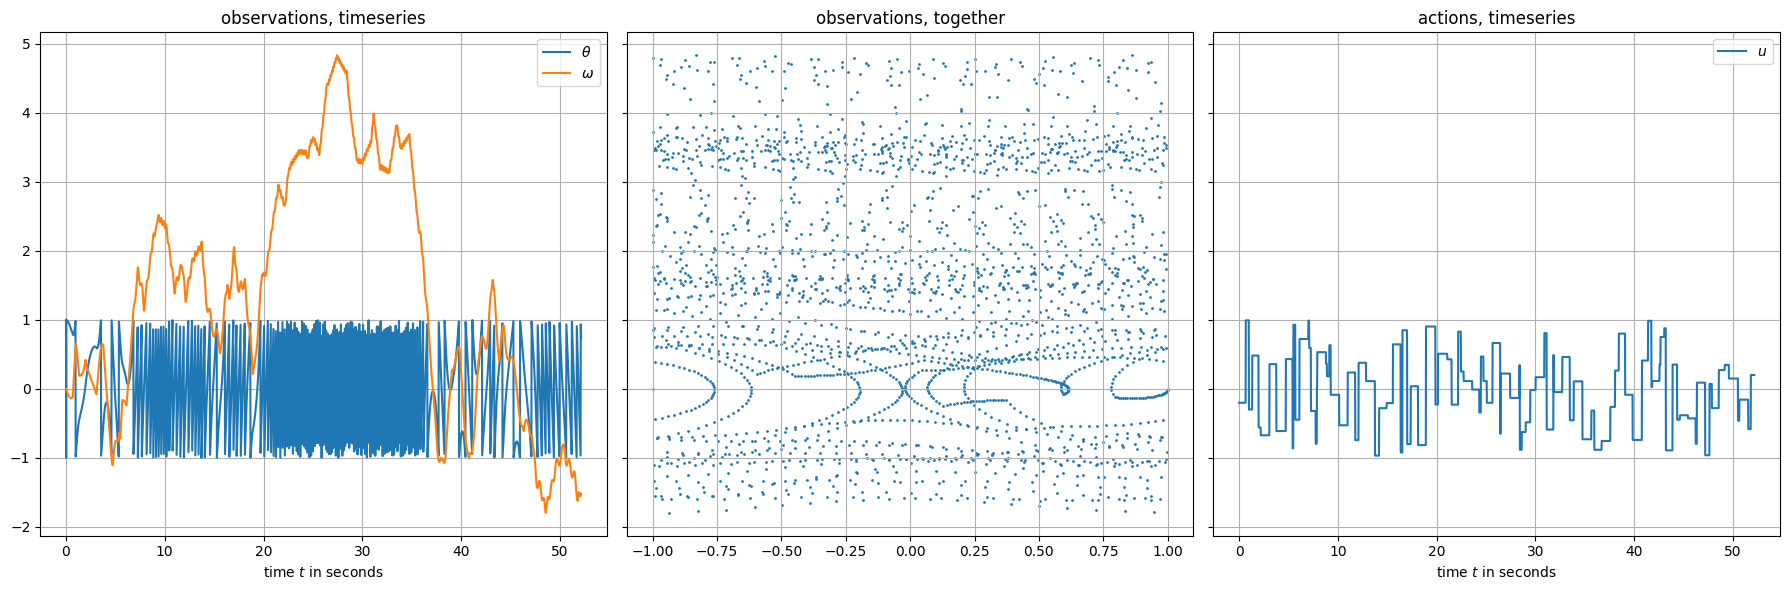

In [9]:
obs, env_state = env.reset()
obs = obs.astype(np.float32)[0]
env_state = env_state.astype(np.float32)[0]

observations, _ = simulate_ahead_with_env(
    env,
    obs,
    env_state,
    actions,
)

print("actions.shape:", actions.shape)
print("observations.shape:", observations.shape)

print(" \n One of the trajectories:")
fig, axs = plot_sequence(
    observations=observations,
    actions=actions,
    tau=tau,
    obs_labels=[r"$\theta$", r"$\omega$"],
    action_labels=[r"$u$"],
);
plt.show()

In [10]:
# jax_env = excenvs.make(
#     env_id='Pendulum-v0',
#     batch_size=batch_size,
#     tau=tau
# )


# jax_observations = jax.vmap(
#     exciting_exciting_systems.models.model_utils.simulate_ahead_with_env,
#     in_axes=(None, 0, 0, 0, 0, 0, 0)
# )(
#     jax_env,
#     obs,
#     env_state,
#     actions,
#     jax_env.env_state_normalizer,
#     jax_env.action_normalizer,
#     jax_env.static_params
# )

# plt.plot(observations[0, :, 0])
# plt.plot(jax_observations[0, :, 0])
# plt.show()

# plt.plot(observations[0, :, 1])
# plt.plot(jax_observations[0, :, 1])
# plt.show()

---

In [11]:
from exciting_exciting_systems.related_work.algorithms import excite_with_iGOATs

In [12]:
def featurize_theta(obs_action):
    """The angle itself is difficult to properly interpret in the loss as angles
    such as 1.99 * pi and 0 are essentially the same. Therefore the angle is 
    transformed to sin(phi) and cos(phi) for comparison in the loss."""

    feat_obs_action = np.stack([np.sin(obs_action[..., 0] * np.pi), np.cos(obs_action[..., 0] * np.pi)], axis=-1)
    feat_obs_action = np.concatenate([feat_obs_action, obs_action[..., 1:]], axis=-1)
    
    return feat_obs_action

In [13]:
h = 2
a = 2

actions = []
observations = []

observations, actions = excite_with_iGOATs(
    n_timesteps=5000,
    env=env,
    actions=actions,
    observations=observations,
    h=h,
    a=a,
    bounds_amplitude=[-1, 1],
    bounds_duration=[1, 50],
    population_size=20,
    n_generations=20,
    mean=np.hstack([np.zeros(h), np.ones(h) * 25]),
    sigma=2.0,
    featurize=featurize_theta
)

  0%|          | 0/5000 [00:00<?, ?it/s]

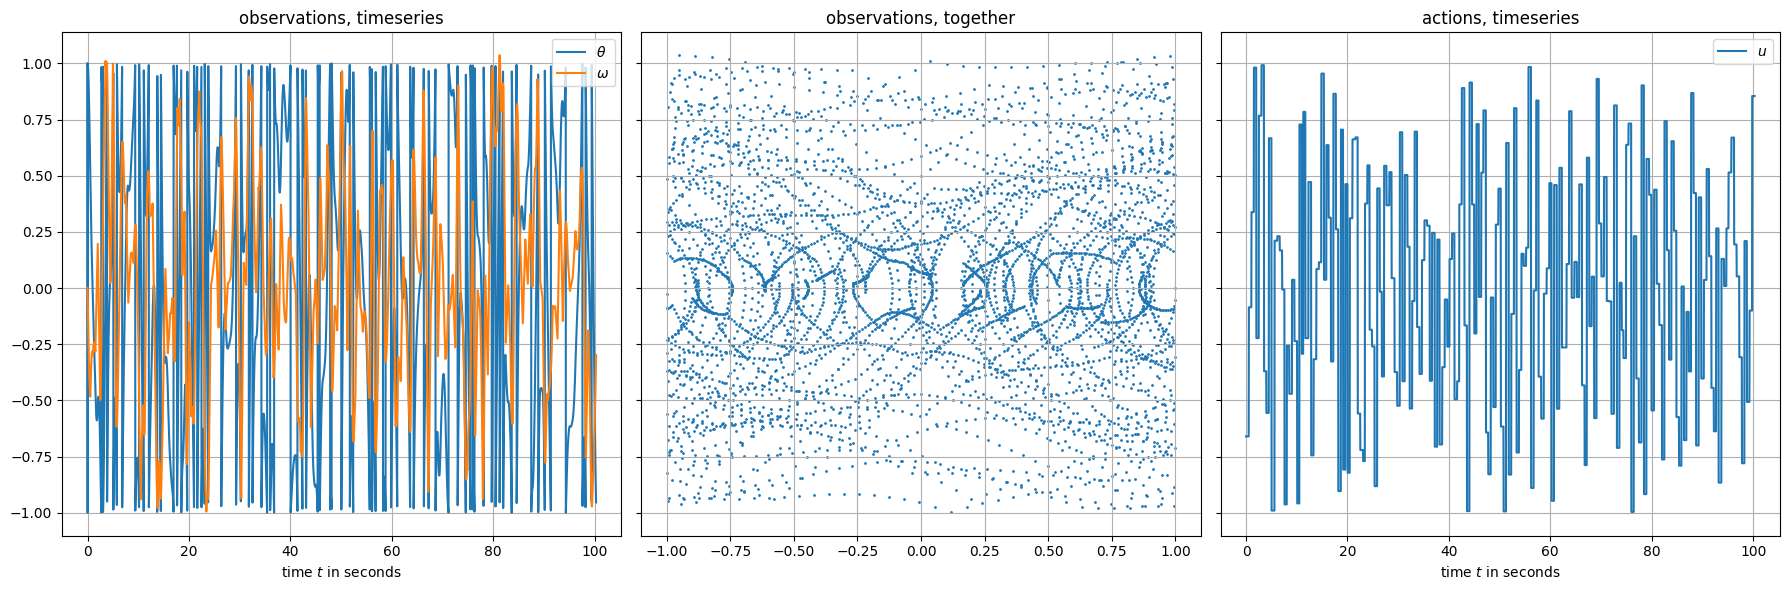

In [16]:
fig, axs = plot_sequence(
    observations=observations,
    actions=actions,
    tau=tau,
    obs_labels=[r"$\theta$", r"$\omega$"],
    action_labels=[r"$u$"],
);
plt.show()

In [17]:
from exciting_exciting_systems.utils.density_estimation import DensityEstimate, build_grid_2d, update_density_estimate_multiple_observations

In [18]:
density_estimate = DensityEstimate(
    p=jnp.zeros([50**2, 1]),
    x_g=build_grid_2d(low=-1, high=1, points_per_dim=50),
    bandwidth=jnp.array([0.05]),
    n_observations=jnp.array([0])
)

density_estimate = update_density_estimate_multiple_observations(
    density_estimate, observations,
)

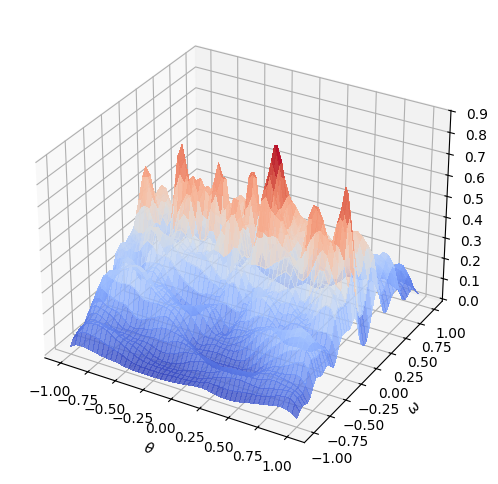

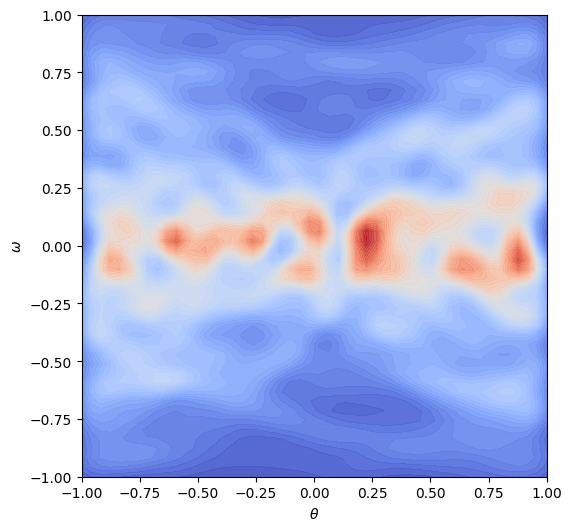

In [19]:
fig, axs = exciting_exciting_systems.evaluation.plotting_utils.plot_2d_kde_as_surface(
    density_estimate.p, density_estimate.x_g, [r"$\theta$", r"$\omega$"]
)
plt.show()

fig, axs, _ = exciting_exciting_systems.evaluation.plotting_utils.plot_2d_kde_as_contourf(
    density_estimate.p, density_estimate.x_g, [r"$\theta$", r"$\omega$"]
)
plt.show()

---

In [20]:
# np.save("obs_iGOATs.npy", np.stack(observations))
# np.save("act_iGOATs.npy", np.stack(actions))

In [21]:
# observations = np.load("obs_iGOATs.npy")
# actions = np.load("act_iGOATs.npy")